In [10]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from ramannoodles import spectrafit
from ramannoodles import shoyu

In [2]:
# open spectra library
shoyu_data_dict = pickle.load(open('../raman_spectra/shoyu_data_dict.p', 'rb'))
# list keys
sorted(shoyu_data_dict.keys())

['2-PROPANOL',
 'CARBON DIOXIDE',
 'CARBON MONOXIDE',
 'DIMETHYL KETONE',
 'ETHYL ALCOHOL',
 'FORMIC ACID',
 'WATER']

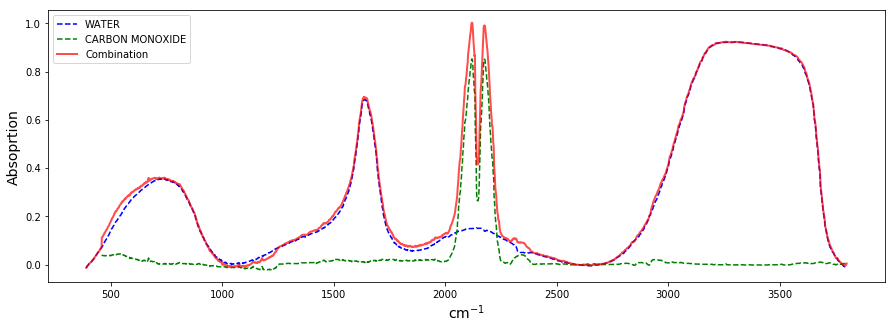

In [3]:
compound_1 = shoyu_data_dict['WATER']
compound_2 = shoyu_data_dict['CARBON MONOXIDE']
compound_3 = shoyu_data_dict['ETHYL ALCOHOL']
compound_4 = shoyu_data_dict['FORMIC ACID']
spectra_x, spectra_y = shoyu.combine_spectra(compound_1, compound_2, plot = True)

In [17]:
print(compound_1['title'])
print(compound_1)

WATER
{'title': 'WATER', 'jcamp-dx': 4.24, 'data type': 'INFRARED SPECTRUM', 'class': 'COBLENTZ III', 'origin': 'DOW CHEMICAL COMPANY', 'owner': 'COBLENTZ SOCIETY', 'date': '1969/10/21', 'cas registry no': '7732-18-5', 'molform': 'H2 O', 'source reference': 'COBLENTZ NO. 10116', '$nist source': 'COBLENTZ', '$nist image': 'cob10116', 'spectrometer/data system': 'DOW KBr FOREPRISM-GRATING', 'instrument parameters': 'BLAZED AT 3.5, 12.0, 20.0 MICRON, CHANGED AT 5.0, 7.5, 14.9 MICRON', 'state': 'LIQUID (NEAT)', 'path length': 'CAPILLARY, AgCl PLATES', 'sampling procedure': 'TRANSMISSION', 'resolution': 4, 'data processing': 'DIGITIZED BY NIST FROM HARD COPY (FROM TWO SEGMENTS)', 'xunits': '1/CM', 'yunits': 'ABSORBANCE', 'xfactor': 1.0, 'yfactor': 1, 'deltax': 0.870985, 'firstx': 388.677, 'lastx': 3799.46, 'firsty': 0.438, 'maxx': 3799.46, 'minx': 388.677, 'maxy': 0.987, 'miny': 0.001, 'npoints': 3917, 'xydata': '(X++(Y..Y))', 'end': '', 'x': array([ 388.677     ,  389.76573175,  390.854463

In [18]:
spectra_x = np.asarray(spectra_x)
spectra_y = np.asarray(spectra_y)

In [5]:
water_peaks = spectrafit.compound_report(compound_1)[0]
co_peaks = spectrafit.compound_report(compound_2)[0]
spectra_peaks = spectrafit.data_report(spectra_x, spectra_y)[0]

In [6]:
ethyl_alcohol_peaks = spectrafit.compound_report(compound_3)[0]
formic_acid_peaks = spectrafit.compound_report(compound_4)[0]

In [7]:
print('Water peaks = {}'.format(water_peaks))
print('CO peaks = {}'.format(co_peaks))
print('Combined Spectra peaks = {}'.format(spectra_peaks))
print('EtOH Spectra peaks = {}'.format(ethyl_alcohol_peaks))
print('formic acid peaks = {}'.format(formic_acid_peaks))

Water peaks = [711.4826030832157, 1638.6886199554203, 3312.1231809302135]
CO peaks = [2109.8548231081886, 2183.58416497579]
Combined Spectra peaks = [708.0, 1638.5198632531205, 2110.0000000000095, 2184.149153919652, 3268.999999970273]
EtOH Spectra peaks = [2.757938608767363, 3.4216112107197514, 7.161978013820123, 8.065277519813382, 9.4628771518764, 15.50571824967875]
formic acid peaks = [639.4717630407281, 700.0006725956375, 916.1238150000007, 1087.4292631196167, 1110.229302896255, 1120.6184463323998, 1211.60193448746, 1365.6941683529176, 1531.5978300000031, 1556.2422171904652, 1664.266539247223, 1732.780516872577, 1765.3434260000004, 1791.8601399436195, 2954.071404999994, 3117.188835832671]


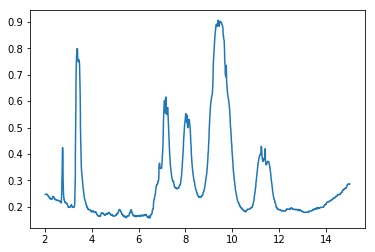

In [9]:
#OK, so the EtOH peaks look very wrong on the x-axis, though the peak positions are just fine I guess? 
plt.plot(compound_3['x'], compound_3['y'])

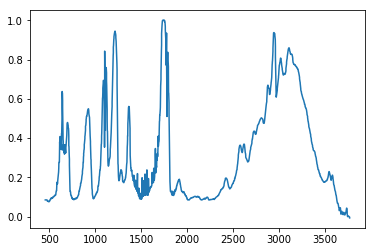

In [10]:
plt.plot(compound_4['x'], compound_4['y'])

In [11]:
#Ok, first things first, let's just compare two and not worry os much. 
water_peaks

[711.4826030832157, 1638.6886199554203, 3312.1231809302135]

# The cell below shows comparison for a single set of peaks (ie, water) against the peaks for the combined spectra. It finds all of them neatly, so that's nice.

In [12]:
#Use this array to keep track of which peaks in spectra_peaks are assigned to what. The position in the array also
#corresponds to the position along spectra_peaks, so it provide positional tracking too. 
soft_assignment_array = np.zeros(len(spectra_peaks))
peaks_found = 0

for i in range(len(spectra_peaks)):
    for j in range(len(water_peaks)):
        if math.isclose(spectra_peaks[i], water_peaks[j], rel_tol = 0.02):
            soft_assignment_array[i] = 1
            peaks_found += 1
            continue
        else:
            pass

    if peaks_found == len(water_peaks):
        continue
    else:
        pass
print(soft_assignment_array)

[1. 1. 0. 0. 1.]


In [13]:
#For the final comparison, take the mean value of the association matrix, and then the one with the biggest association 
#matrix individual values will take primacy. Don't delete secondary peaks, just state that they are secondary. 

In [14]:
#function calculates distance start
def peak_1D_score(rowA,rowB):
    "docstring"
    scores = []
    
    #calculate distance between peaks
    #√((x1-x2)^2 + (y1-y2)^2)

    for i in range(len(rowA)):
        for j in range(len(rowB)):
            distance = np.where((rowA[i] - rowB[j]>10),np.nan,sum([math.pow(rowA[i] - rowB[j], 2)]))
            distance = math.sqrt(distance)
            if (1/(distance + 1)>.05):
                scores.append(((rowA[i],rowB[j]),(1/(distance + 1))))

    return scores
def score_sort(list_input, row):
    """
    Returns list of scores sorted

    Parameters:
        list_input (list):  input list to iterate
        row (list): input list

    Returns:
        sorteddistances (list): sorted Euclidean distances
    """
    sorteddistances = []
    for index_i in range(len(list_input)):
        sorteddistances.append((peak_1D_score(row, list_input[index_i]),index_i))
    sorteddistances.sort()
    return sorteddistances

In [19]:
# def generate_peak_pandas(shoyu_dictionary):
#     """This function takes in a key and value entry from the shoyu_data_dict, and uses that to generate a pandas 
#     dataframe."""
    
#     shoyu_peaks = spectrafit.compound_report(shoyu_dictionary)[0]
#     shoyu_title = shoyu_dictionary['title']
#     print(shoyu_peaks)
#     print(shoyu_title)
#     shoyu_dataframe = pd.DataFrame(data = shoyu_peaks, columns = shoyu_title)
    
#     return shoyu_dataframe

In [20]:
# water_dataframe = generate_peak_pandas(compound_1)

[711.4826030832157, 1638.6886199554203, 3312.1231809302135]
WATER


TypeError: Index(...) must be called with a collection of some kind, 'WATER' was passed

In [40]:
known_compound_list = [compound_1, compound_2, compound_4]
known_compound_list[0]['title']
print(spectrafit.compound_report(known_compound_list[1])[0])
len(known_compound_list)
peaks = np.zeros(3)

[2109.8548231081886, 2183.58416497579]


In [31]:
compound_list

[{'title': 'WATER',
  'jcamp-dx': 4.24,
  'data type': 'INFRARED SPECTRUM',
  'class': 'COBLENTZ III',
  'origin': 'DOW CHEMICAL COMPANY',
  'owner': 'COBLENTZ SOCIETY',
  'date': '1969/10/21',
  'cas registry no': '7732-18-5',
  'molform': 'H2 O',
  'source reference': 'COBLENTZ NO. 10116',
  '$nist source': 'COBLENTZ',
  '$nist image': 'cob10116',
  'spectrometer/data system': 'DOW KBr FOREPRISM-GRATING',
  'instrument parameters': 'BLAZED AT 3.5, 12.0, 20.0 MICRON, CHANGED AT 5.0, 7.5, 14.9 MICRON',
  'state': 'LIQUID (NEAT)',
  'path length': 'CAPILLARY, AgCl PLATES',
  'sampling procedure': 'TRANSMISSION',
  'resolution': 4,
  'data processing': 'DIGITIZED BY NIST FROM HARD COPY (FROM TWO SEGMENTS)',
  'xunits': '1/CM',
  'yunits': 'ABSORBANCE',
  'xfactor': 1.0,
  'yfactor': 1,
  'deltax': 0.870985,
  'firstx': 388.677,
  'lastx': 3799.46,
  'firsty': 0.438,
  'maxx': 3799.46,
  'minx': 388.677,
  'maxy': 0.987,
  'miny': 0.001,
  'npoints': 3917,
  'xydata': '(X++(Y..Y))',
  'en

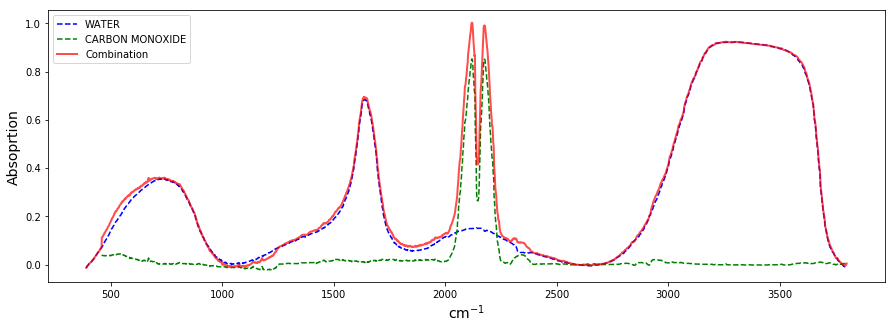

In [32]:
#Generate the unknown spectra by combining two spectra. 
spectra_x, spectra_y = shoyu.combine_spectra(compound_1, compound_2, plot = True)
spectra_x = np.asarray(spectra_x)
spectra_y = np.asarray(spectra_y)

In [49]:
testarray = []
testarray.append(spectrafit.compound_report(known_compound_list[i])[0])
print(testarray)

[[711.4826030832157, 1638.6886199554203, 3312.1231809302135]]


In [52]:
#Lets identify the peaks in the unknown spectrum. 

unknown_peaks = spectrafit.data_report(spectra_x, spectra_y)[0]
    
#OK, next identify all of the peaks present in the known compound set. 
#For efficiency, we'll also compare them against the unknown in the same for loop.
known_compound_peaks = []
association_matrix = []
print(known_compound_peaks)
for i in range(len(known_compound_list)):
    known_compound_peaks.append(spectrafit.compound_report(known_compound_list[i])[0])
    print("The peaks that we found for " + str(known_compound_list[i]['title']) + " are: ")
    print(known_compound_peaks[i])
    association_matrix.append(compare_unknown_to_known(unknown_peaks, known_compound_peaks[i], precision=0.03))

print(known_compound_peaks)
print(association_matrix)

[]
The peaks that we found for WATER are: 
[711.4826030832157, 1638.6886199554203, 3312.1231809302135]
The peaks that we found for CARBON MONOXIDE are: 
[2109.8548231081886, 2183.58416497579]
The peaks that we found for FORMIC ACID are: 
[639.4717630407281, 700.0006725956375, 916.1238150000007, 1087.4292631196167, 1110.229302896255, 1120.6184463323998, 1211.60193448746, 1365.6941683529176, 1531.5978300000031, 1556.2422171904652, 1664.266539247223, 1732.780516872577, 1765.3434260000004, 1791.8601399436195, 2954.071404999994, 3117.188835832671]
[[711.4826030832157, 1638.6886199554203, 3312.1231809302135], [2109.8548231081886, 2183.58416497579], [639.4717630407281, 700.0006725956375, 916.1238150000007, 1087.4292631196167, 1110.229302896255, 1120.6184463323998, 1211.60193448746, 1365.6941683529176, 1531.5978300000031, 1556.2422171904652, 1664.266539247223, 1732.780516872577, 1765.3434260000004, 1791.8601399436195, 2954.071404999994, 3117.188835832671]]
[array([1., 1., 0., 0., 1.]), array([

In [56]:
association_matrix[1][2]

1.0

In [ ]:
#Writing a wrapper function that calls stuff and keeps everything organized. 
def wrapper(unknown_x, unknown_y, known_compound_list, precision = 0.03):
    """This function is a wrapper function from which all classification of peaks occurs."""
    #Lets identify the peaks in the unknown spectrum. 
    unknown_peaks = spectrafit.data_report(unknown_x, unknown_y)[0]
    
    #OK, next identify all of the peaks present in the known compound set. 
    #For efficiency, we'll also compare them against the unknown in the same for loop.
    known_compound_peaks = []
    association_matrix = []
    
    for i in range(len(known_compound_list)):
        known_compound_peaks.append(spectrafit.compound_report(known_compound_list[i])[0])
        print("The peaks that we found for " + str(known_compound_list[i]['title']) + " are: ")
        print(known_compound_peaks[i])
        association_matrix.append(compare_unknown_to_known(unknown_peaks, known_compound_peaks[i], precision))
    
    #Ok, so that generates a full association matrix that contains everything we need to assign peaks. 
    #Now, let's go through and actually assign text to peaks. 
    

In [22]:
#Ok, in order to modularize this, we need to make that above a generalizable function. NBD!
def compare_unknown_to_known(combined_peaks, known_peaks, precision):
    """This function takes in peak positions for the spectrum to be analyzed and a single known compound and 
    determines if the peaks found in the known compound are present in the unknown spectrum."""
    assignment_matrix = np.zeros(len(combined_peaks))
    peaks_found = 0
    for i in range(len(combined_peaks)):
        for j in range(len(known_peaks)):
            #instead of If, call peak_1D_score
            if math.isclose(combined_peaks[i], known_peaks[j], rel_tol = precision):
                #Instead of using a 1, just input the score from the score calculator. Bigger is better.
                #Storing only the second component in the list. 
                assignment_matrix[i] = 1
                peaks_found += 1
                continue
            else:
                pass
        if peaks_found == len(known_peaks):
            continue
        else:
            pass
    return assignment_matrix

In [16]:
water_assignment_matrix = compare_unknown_to_known(spectra_peaks, water_peaks, 0.02)
co_assignment_matrix = compare_unknown_to_known(spectra_peaks, co_peaks, 0.02)
print(water_assignment_matrix)
print(co_assignment_matrix)

[1. 1. 0. 0. 1.]
[0. 0. 1. 1. 0.]


In [17]:
#Alright, now, code functionality that enables assignment of text to peak positions.
unknown_text_assignment = []
for i in range(len(spectra_peaks)):
    position_assignment = []
    if water_assignment_matrix[i] == 1:
        position_assignment.append("WATER")
    if co_assignment_matrix[i] == 1:
        position_assignment.append("CO")
    unknown_text_assignment.append(position_assignment)
print(unknown_text_assignment)

[['WATER'], ['WATER'], ['CO'], ['CO'], ['WATER']]


# Magnificent. Hard-coded to holy hell, but hey! We can assign peaks to have words associated with them. Good stuff

In [18]:
print(compound_1['title'])

WATER


In [19]:
known_compounds = [compound_1, compound_2, compound_4]
print(known_compounds)
print(known_compounds[1]['title'])
for i in range(len(known_compounds)):
        known_peaks.append(spectrafit.compound_report(known_compounds[i])[0])
        
print(known_peaks)

[{'title': 'WATER', 'jcamp-dx': 4.24, 'data type': 'INFRARED SPECTRUM', 'class': 'COBLENTZ III', 'origin': 'DOW CHEMICAL COMPANY', 'owner': 'COBLENTZ SOCIETY', 'date': '1969/10/21', 'cas registry no': '7732-18-5', 'molform': 'H2 O', 'source reference': 'COBLENTZ NO. 10116', '$nist source': 'COBLENTZ', '$nist image': 'cob10116', 'spectrometer/data system': 'DOW KBr FOREPRISM-GRATING', 'instrument parameters': 'BLAZED AT 3.5, 12.0, 20.0 MICRON, CHANGED AT 5.0, 7.5, 14.9 MICRON', 'state': 'LIQUID (NEAT)', 'path length': 'CAPILLARY, AgCl PLATES', 'sampling procedure': 'TRANSMISSION', 'resolution': 4, 'data processing': 'DIGITIZED BY NIST FROM HARD COPY (FROM TWO SEGMENTS)', 'xunits': '1/CM', 'yunits': 'ABSORBANCE', 'xfactor': 1.0, 'yfactor': 1, 'deltax': 0.870985, 'firstx': 388.677, 'lastx': 3799.46, 'firsty': 0.438, 'maxx': 3799.46, 'minx': 388.677, 'maxy': 0.987, 'miny': 0.001, 'npoints': 3917, 'xydata': '(X++(Y..Y))', 'end': '', 'x': array([ 388.677     ,  389.76573175,  390.8544635 , .

NameError: name 'known_peaks' is not defined

In [20]:
len(known_compounds)

3

# OK, so I have no idea what the issue is, but this method doesn't work. 
It seems like the issue is that putting all of the compounds into a list like I did messes up its abilities to be interacted with using spectrafit. I think the right workaround is to use spectrafit to generate all the peaks first, then make them into a list, but the problem is that doing that eliminates my ability to pull out the title of the peaks later. Maybe the answer is 
to load them into pandas instead? 

In [27]:
#known peaks will be passed in as a list of compounds! Access titles by 'title' 
def assign_peaks(unknown_peaks, known_compounds, precision = 0.03):
    """Wrapper function. Woot."""
    known_peaks = []
    for i in range(len(known_compounds)):
        #Initialize a list that has the peaks for each compound in the known compound array
        compound = known_compounds[i]
        known_peaks.append(spectrafit.compound_report(compound)[0])
    #Initialize a list that contains the peaks for the analysis spectra
    #unknown_peaks = spectrafit.compound_report(unknown_compound_peaks)[0]
    print("You've gotten through appending all of the known peak functions")
    print(known_peaks)
    #Initialize an empty association matrix
    association_matrix = []
    
    #Once we've put together the peak list, we need to cross-compare the lists and figure out which peaks match.
    for i in range(len(known_compounds)):
        print("You've called the association matrix calculation on peak " + str(known_peaks[i]['title']))
        association_matrix.append(compare_unknown_to_known(unknown_peaks, known_peaks[i], precision))
        
    #Now we call a different function to assign text labels to each peak.
    unknown_peak_assignment = peak_position_comparisons(unknown_peaks, known_peaks, known_compounds, association_matrix)
    
    
    
    #for i in range(len(spectra_peaks)):
     #   position_assignment = []

    

In [25]:
def peak_position_comparisons(unknown_peaks, known_peaks, known_compounds, association_matrix):
    unknown_peak_assignment = []
    for i in range(len(unknown_peaks)):
        position_assignment = []
        for j in range(len(known_peaks)):
            if association_matrix[j][i] == 1:
                position_assignment.append(known_compounds[i]['title'])
            else:
                pass
        unkown_peak_assignment.append(position_assignment)
    
    return unknown_peak_assignment

In [59]:
#Ok, we've got assignments! For now, we won't resolved conflicts. We'll just add both labels to the same peak. 
#If we nest the loops through the water in 
unknown_text_assignment = []
known_compound_name = "WATER"
for i in range(len(water_assignment_matrix)):
    if water_assignment_matrix[i] == 1:
        unknown_text_assignment.append(known_compound_name)
    else:
        unknown_text_assignment.append("Unassigned")
print("Your matrix situation after " + str(known_compound_name) + " peak assignments are: " + str(unknown_text_assignment))

for i in range(len(co_assignment_matrix))

Your matrix situation after WATER peak assignments are: ['WATER', 'WATER', 'Unassigned', 'Unassigned', 'WATER']


In [21]:
known_peaks = []

In [22]:
compound = known_compounds[2]
known_peaks.append(spectrafit.compound_report(compound)[0])
print(known_peaks)
# print(spectra_peaks)
#print(known_peaks)

[[639.4717630407281, 700.0006725956375, 916.1238150000007, 1087.4292631196167, 1110.229302896255, 1120.6184463323998, 1211.60193448746, 1365.6941683529176, 1531.5978300000031, 1556.2422171904652, 1664.266539247223, 1732.780516872577, 1765.3434260000004, 1791.8601399436195, 2954.071404999994, 3117.188835832671]]


In [ ]:
#Lets turn that into a generic function.
#Assume that we have a different wrapper that generates our assignment lists. 
#We will also assume that we know which dictionary entries are associated with which known peaks. This fixes 
#some of the issues with hardcoding in the above section. 
def assign_peak_names(unknown_peaks, known_peaks, precision):
    
    water_assignment_matrix = compare_unknown_to_known(spectra_peaks, water_peaks, 0.02)
    co_assignment_matrix = compare_unknown_to_known(spectra_peaks, co_peaks, 0.02)
    
    unknown_text_assignment = []
    for i in range(len(spectra_peaks)):
        position_assignment = []
        if water_assignment_matrix[i] == 1:
            position_assignment.append("WATER")
        if co_assignment_matrix[i] == 1:
            position_assignment.append("CO")
        unknown_text_assignment.append(position_assignment)
    
    
    return unknown_text_assigment

In [28]:
assign_peaks(spectra_peaks, known_compounds)

You've gotten through appending all of the known peak functions
[[711.4826030832157, 1638.6886199554203, 3312.1231809302135], [2109.8548231081886, 2183.58416497579], [639.4717630407281, 700.0006725956375, 916.1238150000007, 1087.4292631196167, 1110.229302896255, 1120.6184463323998, 1211.60193448746, 1365.6941683529176, 1531.5978300000031, 1556.2422171904652, 1664.266539247223, 1732.780516872577, 1765.3434260000004, 1791.8601399436195, 2954.071404999994, 3117.188835832671]]


TypeError: list indices must be integers or slices, not str

In [43]:
    unknown_peak_assignment = []
    for i in range(len(spectra_peaks)):
        position_assignment = []
        for j in range(len(known_peaks)):
            if association_matrix[j][i] == 1:
                position_assignment.append(known_compounds[i]['title'])
            else:
                pass
        unkown_peak_assignment.append(position_assignment)

NameError: name 'association_matrix' is not defined

In [ ]:
for i in range(len(spectra_peaks)):
    position_assignment = []
    if water_assignment_matrix[i] == 1:
        position_assignment.append("WATER")
    if co_assignment_matrix[i] == 1:
        position_assignment.append("CO")
    unknown_text_assignment.append(position_assignment)
print(unknown_text_assignment)

In [85]:
#Ok, let's quickly run a test of something that is not in the combined spectrum and see how it handles it. 
#Let's try it with formic acid.
print(formic_acid_peaks)
print(spectra_peaks)

[639.4717630407281, 700.0006725956375, 916.1238150000007, 1087.4292631196167, 1110.229302896255, 1120.6184463323998, 1211.60193448746, 1365.6941683529176, 1531.5978300000031, 1556.2422171904652, 1664.266539247223, 1732.780516872577, 1765.3434260000004, 1791.8601399436195, 2954.071404999994, 3117.188835832671]
[708.0, 1638.5198632531205, 2110.0000000000095, 2184.149153919652, 3268.999999970273]


In [84]:
formic_acid_assignment_matrix = compare_unknown_to_known(spectra_peaks, formic_acid_peaks, 0.02)
print(formic_acid_assignment_matrix)

[1. 1. 0. 0. 0.]


In [ ]:
#We have a touch of a problem with this one. If you have a messy enough spectra, it seems to assign things willy nilly. 
#We'll have to figure out some sort of weighting function to sort that out. 

In [90]:
#Ok, lets see how this previous code-block works if we add in the conflating issue of assigning two peaks to a signle spot.
unknown_text_assignment = []
for i in range(len(spectra_peaks)):
    position_assignment = []
    if water_assignment_matrix[i] == 1:
        position_assignment.append("WATER")
    if co_assignment_matrix[i] == 1:
        position_assignment.append("CO")
    if formic_acid_assignment_matrix[i] == 1:
        position_assignment.append("FORMIC ACID")
    unknown_text_assignment.append(position_assignment)
print(unknown_text_assignment)
print(unknown_text_assignment[0][0])

[['WATER', 'FORMIC ACID'], ['WATER', 'FORMIC ACID'], ['CO'], ['CO'], ['WATER']]
WATER


### Alrighty. We did ok there, and it handles the problem of having multiple possible compounds for a single peak in an acceptable way for now. Next step is to derivatize it.

***

In [3]:
#function calculates distance start
def peak_1D_score(rowA,rowB):
    "docstring"
    scores = []
    
    #calculate distance between peaks
    #√((x1-x2)^2 + (y1-y2)^2)

    for i in range(len(rowA)):
        for j in range(len(rowB)):
            distance = np.where((rowA[i] - rowB[j]>10),np.nan,sum([math.pow(rowA[i] - rowB[j], 2)]))
            distance = math.sqrt(distance)
            if (1/(distance + 1)>.05):
                scores.append(((rowA[i],rowB[j]),(1/(distance + 1))))

    return scores
def score_sort(list_input, row):
    """
    Returns list of scores sorted

    Parameters:
        list_input (list):  input list to iterate
        row (list): input list

    Returns:
        sorteddistances (list): sorted Euclidean distances
    """
    sorteddistances = []
    for index_i in range(len(list_input)):
        sorteddistances.append((peak_1D_score(row, list_input[index_i]),index_i))
    sorteddistances.sort()
    return sorteddistances

In [8]:
#Next, we'll need to look at the combined spectra peaks and try to ascribe the peaks. 
#I think we'll need to tell it if it sees the water peaks first.
#ie, write the function as though we'll tell it exactly what to look for first. 

#add new column to label what spectra each peak in the analyzed spectra is coming from. I think that means we 
#need to switch over to a pandas dataframe, rather than a numpy array. 


#We could loop through and check each position of the spectra peaks. At each position, we could look through all 
#of the user inputted peaks that are worth comparing(ie, define as a function, and have possible_peaks be an
#array of compounds to take as an input.) At peak position 1, we could look through and say ok, we've got 
#5 compounds in the testing function. Lets compare the peak max at peak position 1 from testing spectra against
#the first peak in every one of the compounds on the test list. If the isclose statement evaluates to true, then
#We will iterate down spectra_peaks and compare that next peak against the second peak in the tested spectra
#If we get through the whole of the spectra_peaks and don't find any more matches, then we know that the tested compound 
#was a no, and we need to 1. ignore it for all future comparisons, and 2. not assign the first peak to be coming from 
#the tested compound. 
#Then, we'll need to keep moving down our inputted list, and comparing each first peak in the inputted list against 
#our first peak. 
#If we can't find a match to the first peak, we then have a statement that assigns the first peak to "Not found!"
#Print out a small error, but then move to the second peak. We might at least be able to define some of the peaks in 
#the spectrum. 


#Strategy, loop through the Combined Spectra Peaks, and compare the first peak. 
for i in len(spectra_peaks):
    for j in len(water_peaks):
        #1% wiggle between the peak maxima. 
        if math.isclose(spectra_peaks[i], water_peaks[i], rel_tol = 0.01):
            #Random function to assign that peak i in spectra peaks is a peak found in water. 
            #Small problem. We're not fully sure that this means that the water peak is def. 
            #the right one. We just know that this first peak is close to water. 
            
        

solicit_user_input(Is peak x close enough to peak y.)
#Alternative would be to report an prediction in terms of a percentage of the fit. That relies on Brandon's work. 

IndentationError: expected an indented block (<ipython-input-8-2fe01ae40c20>, line 36)